# Ungraded Lab: Coding a Wide and Deep Model

In this lab, we'll show how you can implement a wide and deep model. We'll first look at how to build it with the Functional API then show how to encapsulate this into a class. Let's get started!

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

## Build the Model

Let's implement the wide and deep model as shown in class. As shown below, the Functional API is very flexible in implementing complex models. 
- You will specify the previous layer when you define a new layer. 
- When you define the `Model`, you will specify the inputs and output.

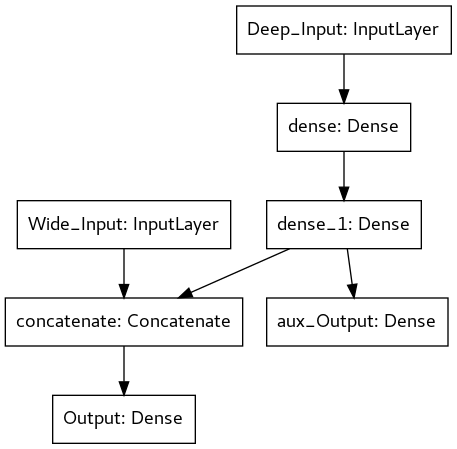

In [2]:
# define inputs
input_a = Input(shape=[1], name="Wide_Input")
input_b = Input(shape=[1], name="Deep_Input")

# define deep path
hidden_1 = Dense(30, activation="relu")(input_b)
hidden_2 = Dense(30, activation="relu")(hidden_1)

# define merged path
concat = concatenate([input_a, hidden_2])
output = Dense(1, name="Output")(concat)

# define another output for the deep path
aux_output = Dense(1,name="aux_Output")(hidden_2)

# build the model
model = Model(inputs=[input_a, input_b], outputs=[output, aux_output])

# visualize the architecture
plot_model(model)

## Implement as a Class

Alternatively, you can also implement this same model as a class. 
- For that, you define a class that inherits from the [Model](https://keras.io/api/models/model/) class.
- Inheriting from the existing `Model` class lets you use the Model methods such as `compile()`, `fit()`, `evaluate()`. 

When inheriting from `Model`, you will want to define at least two functions:
- `__init__()`: you will initialize the instance attributes.
- `call()`: you will build the network and return the output layers.

If you compare the two methods, the structure is very similar, except when using the class, you'll define all the layers in one function, `init`, and connect the layers together in another function, `call`.

In [3]:
# inherit from the Model base class
class WideAndDeepModel(Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)

    def call(self, inputs):
        '''defines the network architecture'''
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        
        return main_output, aux_output


In [4]:
# create an instance of the model
model = WideAndDeepModel()

In [9]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  210       
_________________________________________________________________
dense_3 (Dense)              multiple                  930       
_________________________________________________________________
dense_4 (Dense)              multiple                  36        
_________________________________________________________________
dense_5 (Dense)              multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [7]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 3.7633 - output_1_loss: 3.6054 - output_2_loss: 5.1841 - val_loss: 4.1708 - val_output_1_loss: 4.1388 - val_output_2_loss: 4.4586
Epoch 2/10
363/363 [==============================] - 0s 870us/step - loss: 1.1131 - output_1_loss: 0.8479 - output_2_loss: 3.4993 - val_loss: 1.0394 - val_output_1_loss: 0.6895 - val_output_2_loss: 4.1891
Epoch 3/10
363/363 [==============================] - 0s 863us/step - loss: 0.8605 - output_1_loss: 0.7036 - output_2_loss: 2.2721 - val_loss: 0.9599 - val_output_1_loss: 0.6369 - val_output_2_loss: 3.8665
Epoch 4/10
363/363 [==============================] - 0s 912us/step - loss: 0.7589 - output_1_loss: 0.6487 - output_2_loss: 1.7507 - val_loss: 0.8933 - val_output_1_loss: 0.6296 - val_output_2_loss: 3.2662
Epoch 5/10
363/363 [==============================] - 0s 880us/step - loss: 0.7184 - output_1_loss: 0.6242 - output_2_loss: 1.5668 - val_loss: 0.8287 - val_output_1_loss: 0.6269 